In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from cmocean import cm as cmo
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

import numpy as np
import pandas as pd
import xarray as xr
import scipy
import glob
import matplotlib.dates as mdates
import datetime
import dask.array as da

In [2]:
hurrloc = "../data/track_data/csvs/Barry_2007.csv"

df = pd.read_csv(hurrloc)
hermlen = len(df[df.columns[0]])

latsN, lonsN = df.columns[4], df.columns[5]
hurrlats = np.asarray(df[latsN])
hurrlons = np.asarray(df[lonsN])

hurrtnum = np.ones_like(hurrlats)
for i in range(len(hurrlats)):
    hdate = datetime.datetime.strptime(df['DATE'][i]+" "+df['TIME'][i], "%m/%d/%Y %H:%M:%S")
    hurrtnum[i] = mdates.date2num(hdate)

In [3]:
Gdata = "http://tds.marine.rutgers.edu/thredds/dodsC/cool/glider/mab/Gridded/20070523T0000_20070619T0000_muri_ru17.nc"

In [4]:
df = xr.open_dataset(Gdata)

In [5]:
df

<xarray.Dataset>
Dimensions:                    (depth: 60, profile: 2862)
Coordinates:
  * depth                      (depth) float64 -1.0 -3.0 -5.0 ... -117.0 -119.0
Dimensions without coordinates: profile
Data variables:
    lat                        (profile) float64 ...
    lon                        (profile) float64 ...
    time                       (profile) datetime64[ns] ...
    salinity                   (profile, depth) float64 ...
    temperature                (profile, depth) float64 ...
    salinity_raw               (profile, depth) float64 ...
    temperature_raw            (profile, depth) float64 ...
    brunt_vaisala_squared      (profile, depth) float64 ...
    brunt_vaisala_squared_raw  (profile, depth) float64 ...
    data_quality_flag          (profile, depth) float64 ...
    bb470                      (profile, depth) float64 ...
    bb532                      (profile, depth) float64 ...
    bb660                      (profile, depth) float64 ...
    bb880                      (profile, depth) float64 ...
    chla                       (profile, depth) float64 ...
    cdom                       (profile, depth) float64 ...
Attributes:
    Title:                           RU glider data on standard depths
    Conventions:                     CF-1.0
    Institution:                     Institute for Marine and Coastal Science...
    source:                          /home/coolgroup/gliderData/archive/
    castfile:                        /home/coolgroup/gliderData/archive/07052...
    casttype:                        DOWN
    project:                         muri
    glider:                          ru17
    ascii_file:                      ru17_2007_142_9_0_sbd
    history:                         Created by /home/hunter/work/matlab/glid...
    DODS_EXTRA.Unlimited_Dimension:  profile

In [6]:
df['mdate'] = mdates.date2num(df.time)

In [7]:
from geopy.distance import geodesic

glats = np.squeeze(df.lat.values)
glons = np.squeeze(df.lon.values)

distance_metric = np.ones((np.size(glats),np.size(hurrlats)))
for i, glatitude in enumerate(glats):
    for j, hlatitude in enumerate(hurrlats):
        glider_LL = (glatitude, glons[i])
        hurr_ll   = (hlatitude, hurrlons[j])
        distance_metric[i,j] = geodesic(glider_LL, hurr_ll).miles

In [8]:
b = np.amin(distance_metric)
print(b)
ktime = np.where(distance_metric == b)[1][0]
eyepassage = hurrtnum[ktime]
mdates.num2date(eyepassage)

0.571886338210426


datetime.datetime(2007, 6, 4, 12, 0, tzinfo=datetime.timezone.utc)

In [9]:
print(df.mdate.shape, df.depth.shape)

D, MDATE = np.meshgrid(df.depth.values,df.mdate.values)

(2862,) (60,)


/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


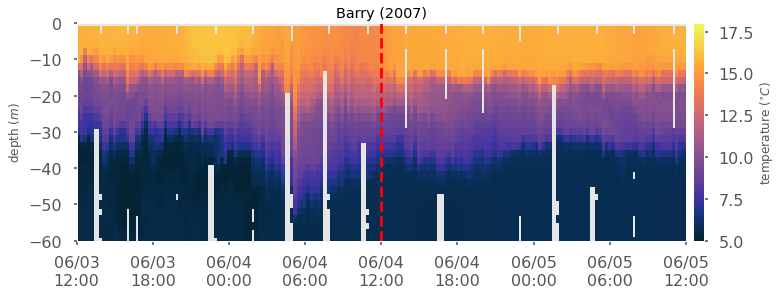

In [10]:
plt.figure(figsize=(13,4))
plt.pcolor(MDATE, D, df.temperature, cmap=cmo.thermal, vmin=5, vmax=18)
plt.colorbar(label='temperature ($^{\circ}C$)',pad=0.01)
plt.ylim([-60,0])
plt.ylabel('depth ($m$)')
myFmt = mdates.DateFormatter('%m/%d\n%H:%M')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.axvline(x = eyepassage, c='r', linestyle="--")
plt.title('Barry (2007)')
plt.savefig("FIGS/temperature_Barry2007.pdf", bbox_inches='tight')
plt.xlim([eyepassage-1,eyepassage+1])
plt.show()

In [11]:
df.depth.values
bef = df.mdate.values < eyepassage-0.5
aft = df.mdate.values > eyepassage-2.5
qb   = np.logical_and(bef,aft)
temps_bef = df.temperature.values[qb,:3]
mean_Tbef = np.nanmean(temps_bef)

bef = df.mdate.values < eyepassage+(1/24)
aft = df.mdate.values > eyepassage-(1/24)
qeye  = np.logical_and(bef,aft)
temps_eye = df.temperature.values[qeye,:3]
mean_Teye = np.nanmean(temps_eye)

bef = df.mdate.values < eyepassage+0.5
aft = df.mdate.values > eyepassage+0.25
qa   = np.logical_and(bef,aft)
temps_aft = df.temperature.values[qa,:3]
mean_Taft = np.nanmean(temps_aft)

Ahead_of_eye_cooling = mean_Tbef - mean_Teye
After_of_eye_cooling = mean_Teye - mean_Taft

print(Ahead_of_eye_cooling, After_of_eye_cooling)

1.2514615635202038 -0.8426506259920643


In [12]:
dense0 = 1022.8
T0     = 17
S0     = 31.5
alpha  = 0.000281
beta   = 0.000766
g      = 9.81

dense = dense0 * (1 + alpha*(df.temperature.values-T0) + beta*(df.salinity.values-S0))
buoy  = -g * dense / dense0

dz = np.gradient(df.depth.values)
db = np.gradient(buoy, axis=[1])
dbdz = -db/dz

dbdz_b = dbdz[qb,:]
dbdz_b.shape
maxN2 = np.ones(dbdz_b.shape[0])
for i in range(dbdz_b.shape[0]):
    prof = dbdz_b[i,:]
    maxN2[i] = np.nanmax(prof)
    
np.nanmean(maxN2)

0.001472275726940195

In [13]:
def pycnocline_width(profile_tmp, d, low=10.5, high=11.5):
    finite = np.where(np.isfinite(profile_tmp))[0]
    maxdepth = d[np.min(finite)]
    mindepth = d[np.max(finite)]
    new_d = np.arange(mindepth,maxdepth,0.1)
    y = interp.interp1d(d[finite],profile_tmp[finite], kind='linear')
    new_tmp = y(new_d)
    tmp_low = np.abs(new_tmp - low)
    tmp_high = np.abs(new_tmp - high)
    q_low = np.where(tmp_low == np.nanmin(tmp_low))[0][0]
    q_high = np.where(tmp_high == np.nanmin(tmp_high))[0][0]
    #delta_d = new_d[q_high] - new_d[q_low]
    return new_d[q_high], new_d[q_low]

import scipy.interpolate as interp

low_depth  = np.ones_like(df['mdate'].values)
high_depth = np.ones_like(df['mdate'].values)

d = df.depth.values

for I in range(len(df['mdate'].values)):
    profile_tmp = df.temperature[I,:].values
    a, b = pycnocline_width(profile_tmp, d, low=12, high=14)
    if np.abs(a-b) < 0.25:
        low_depth[I], high_depth[I] = np.nan, np.nan
    else:
        low_depth[I], high_depth[I] = a, b

In [14]:
Pw_bef = np.nanmedian(low_depth[qb]-high_depth[qb])
Pw_eye = np.nanmedian(low_depth[qeye]-high_depth[qeye])
Pw_aft = np.nanmedian(low_depth[qa]-high_depth[qa])

Pw_bef, Pw_eye, Pw_aft, np.nanmean(high_depth[qb])-np.nanmean(high_depth[qeye])

(1.900000000000027, 5.150000000000073, 2.10000000000003, 6.816768292683003)

In [22]:
winddata = "../data/ndbc_years/44009h2007.txt"

ndb = pd.read_csv(winddata, skiprows=[1], delim_whitespace=True)
ndb_datenum = [mdates.date2num(datetime.datetime(ndb['#YY'][i],ndb['MM'][i],ndb['DD'][i],ndb['hh'][i],ndb['mm'][i])) 
               for i in range(len(ndb))]
ndb_datenum = np.asarray(ndb_datenum)

In [56]:
list(ndb)

['#YY',
 'MM',
 'DD',
 'hh',
 'mm',
 'WDIR',
 'WSPD',
 'GST',
 'WVHT',
 'DPD',
 'APD',
 'MWD',
 'PRES',
 'ATMP',
 'WTMP',
 'DEWP',
 'VIS',
 'TIDE']

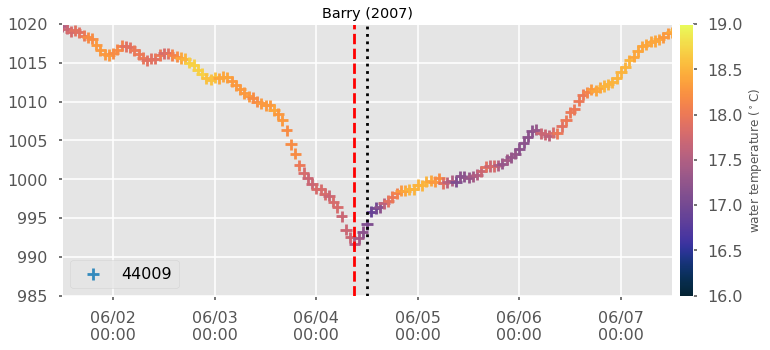

In [50]:
plt.figure(figsize=(13,5))
plt.scatter(ndb_datenum, ndb['PRES'], c=ndb['WTMP'], vmin=16, vmax=19, cmap=cmo.thermal, marker="+", label="44009")
plt.colorbar(pad=0.01,label='water temperature ($^\circ$C)')
plt.legend()
#plt.axvline(x = eyepassage-1/24, c='r', linestyle=":")
plt.ylim([985,1020])
plt.xlim([eyepassage-3,eyepassage+3])
#plt.axvline(x = eyepassage, c='k', linestyle=":")
plt.axvline(x = eyepassage-3/24, c='r', linestyle="--")
plt.title('Barry (2007)')
plt.gca().xaxis.set_major_formatter(myFmt)

In [112]:
eyeB = eyepassage-3/24

def cooling_defs_1D(datenums,eyepassage,wtemp):
    bef = datenums < eyepassage-0.5
    aft = datenums > eyepassage-2.0
    qb   = np.logical_and(bef,aft)
    temps_bef = wtemp[qb]
    mean_Tbef = np.nanmean(temps_bef)

    bef = datenums < eyepassage+(1/24)
    aft = datenums > eyepassage-(1/24)
    qeye  = np.logical_and(bef,aft)
    temps_eye = wtemp[qeye]
    mean_Teye = np.nanmean(temps_eye)

    bef = datenums < eyepassage+0.5
    aft = datenums > eyepassage+0.25
    qa   = np.logical_and(bef,aft)
    temps_aft = wtemp[qa]
    mean_Taft = np.nanmean(temps_aft)

    Ahead_of_eye_cooling = mean_Tbef - mean_Teye
    After_of_eye_cooling = mean_Teye - mean_Taft

    return(Ahead_of_eye_cooling, After_of_eye_cooling)

cooling_defs_1D(ndb_datenum,eyeB,ndb['WTMP'].values)

(0.8142857142857132, -0.4799999999999969)

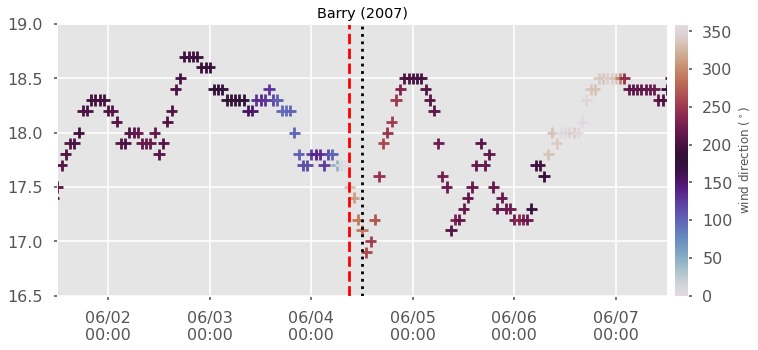

In [59]:
plt.figure(figsize=(13,5))
plt.scatter(ndb_datenum,ndb['WTMP'], marker="+", label="44009", c=ndb['WDIR'], vmax=360, vmin=0, cmap='twilight')
plt.colorbar(pad=0.01,label='wind direction ($^\circ$)')
plt.xlim([eyepassage-3,eyepassage+3])
plt.ylim([16.5,19])
plt.title('Barry (2007)')
plt.axvline(x = eyepassage, c='k', linestyle=":")
plt.axvline(x = eyepassage-3/24, c='r', linestyle="--")
plt.gca().xaxis.set_major_formatter(myFmt)

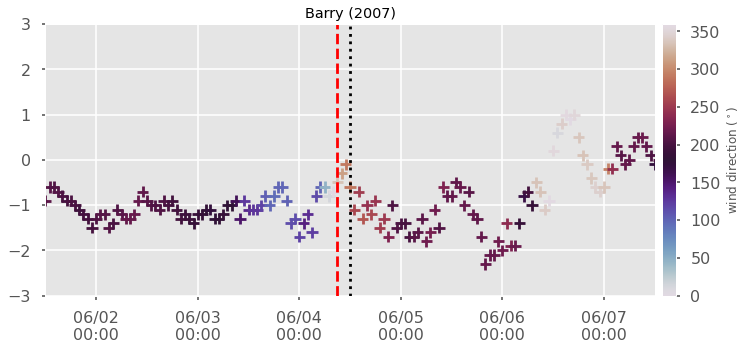

In [61]:
plt.figure(figsize=(13,5))
plt.scatter(ndb_datenum,ndb['WTMP']-ndb['ATMP'], marker="+", label="44009", c=ndb['WDIR'], vmax=360, vmin=0, cmap='twilight')
plt.colorbar(pad=0.01,label='wind direction ($^\circ$)')
plt.xlim([eyepassage-3,eyepassage+3])
plt.ylim([-3,3])
plt.title('Barry (2007)')
plt.axvline(x = eyepassage, c='k', linestyle=":")
plt.axvline(x = eyepassage-3/24, c='r', linestyle="--")
plt.gca().xaxis.set_major_formatter(myFmt)

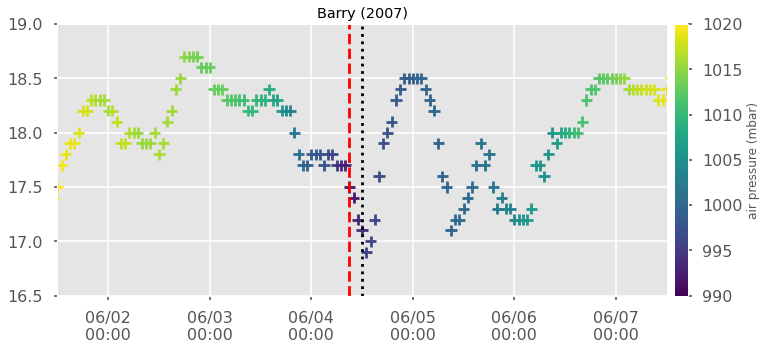

In [55]:
plt.figure(figsize=(13,5))
plt.scatter(ndb_datenum,ndb['WTMP'], marker="+", label="44009", c=ndb['PRES'], vmax=990, vmin=1020, cmap='viridis')
plt.axvline(x = eyepassage, c='k', linestyle=":")
plt.axvline(x = eyepassage-3/24, c='r', linestyle="--")
plt.colorbar(pad=0.01,label='air pressure ($^\circ$)')
plt.xlim([eyepassage-3,eyepassage+3])
plt.ylim([16.5,19])
plt.title('Barry (2007)')
plt.gca().xaxis.set_major_formatter(myFmt)

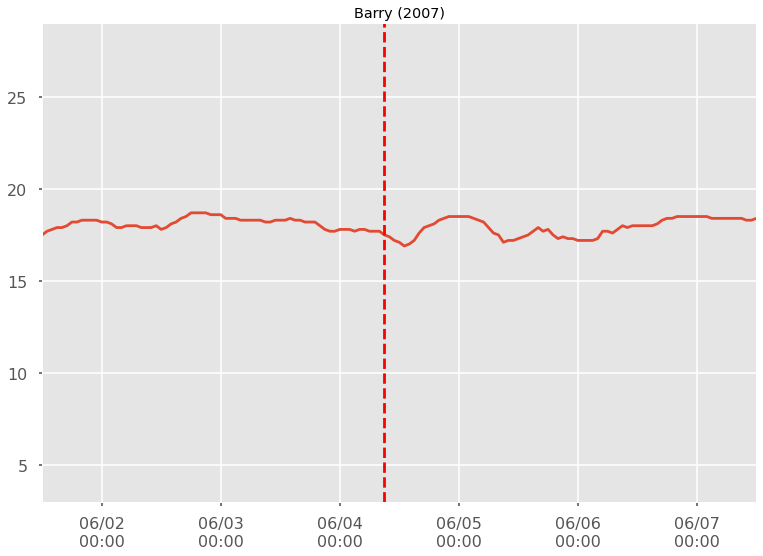

In [71]:
plt.plot(ndb_datenum,ndb['WTMP'])
plt.xlim([eyepassage-3,eyepassage+3])
plt.ylim([3,29])
plt.axvline(x = eyepassage-3/24, c='r', linestyle="--")
plt.xlim([eyepassage-3,eyepassage+3])
plt.title('Barry (2007)')
plt.gca().xaxis.set_major_formatter(myFmt)